In [10]:
from openai import OpenAI
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

In [11]:
openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI()

In [19]:
def load_and_embed_csv(csv_path: str, model: str = "text-embedding-ada-002") -> pd.DataFrame:
    """
    CSV 파일을 불러와 각 행의 모든 컬럼 정보를 결합한 후,
    최신 OpenAI 임베딩 API(client.embeddings.create)를 사용하여 임베딩 벡터를 생성하고
    DataFrame에 'combined_text'와 'embedding' 컬럼을 추가합니다.
    
    Args:
        csv_path (str): CSV 파일 경로.
        model (str): 사용할 임베딩 모델 (기본값: "text-embedding-ada-002").
        
    Returns:
        pd.DataFrame: 원본 데이터에 'combined_text'와 'embedding' 컬럼이 추가된 DataFrame.
    """
    # CSV 파일 로드
    df = pd.read_csv(csv_path)
    
    # CSV 컬럼명 확인 (디버깅용)
    print("CSV 파일의 컬럼:", df.columns.tolist())
    
    # 모든 컬럼 정보를 "컬럼명: 값" 형식으로 결합
    def combine_info(row):
        info_lines = [f"{col}: {row[col]}" for col in row.index]
        return "\n".join(info_lines)
    
    df["combined_text"] = df.apply(combine_info, axis=1)
    
    # 텍스트 임베딩 생성 함수 (최신 API 사용)
    def get_embedding(text: str) -> list:
        response = client.embeddings.create(
            model=model,
            input=text,
            encoding_format="float"
        )
        # 속성 접근 방식 사용
        return response.data[0].embedding
    
    # 각 행의 결합된 텍스트에 대해 임베딩 생성
    df["embedding"] = df["combined_text"].apply(get_embedding)
    
    return df

CSV 파일의 컬럼: ['name', 'coordinate', 'information', 'region', 'writter', 'coordinate.1', 'painting', 'potery', 'royal', 'impressionist', 'furniture', 'religion', 'buda', 'shamanism', 'Christianus', 'korea', 'hindu', 'egyptian', 'natural history', 'fossil', 'dinosaur', 'animal', 'mineral']
임베딩 생성 완료. DataFrame 미리보기:
                                                name  \
0            Gyeongbokgung_Manchunjeon_Foldingscreen   
1                                       Ilwolobongdo   
2  Celadon Prunus Vase with Inlaid Chrysanthemum,...   
3                  Gold Crown From Cheonmachong Tomb   
4                     Unhyun_ White Porcelain Bottle   

                 coordinate  \
0  (0.63699,-20.64571,0.03)   
1        (0.61085,-9.2,0.0)   
2      (-24.0,-8.66634,1.0)   
3    (24.01586,-7.9648,1.5)   
4     (-24.0,-14.83924,1.0)   

                                         information  region writter  \
0  Foldingscreen It is one of the props reproduce...       0     NaN   
1  Ilwolobongdo I

/home/usr/.conda/envs/ex/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/usr/.conda/envs/ex/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/usr/.conda/envs/ex/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/usr/.conda/envs/ex/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/usr/.conda/envs/ex/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing fro

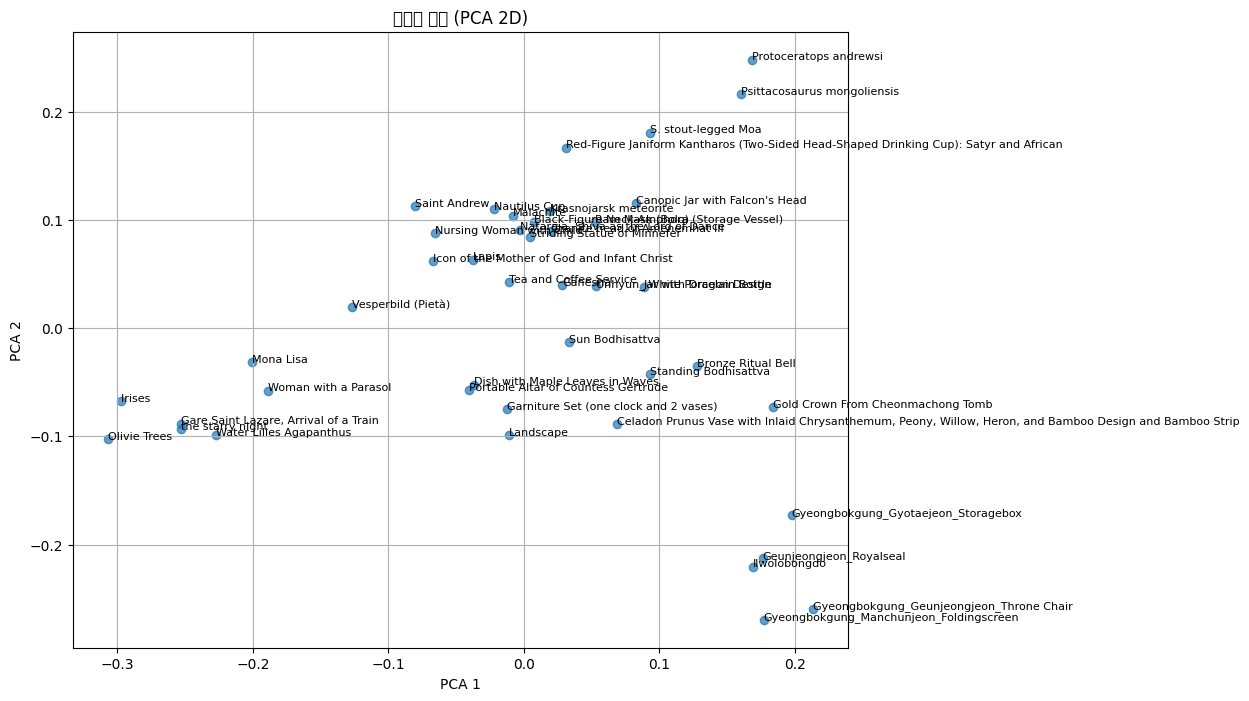

In [21]:
if __name__ == "__main__":
    # 테스트용 CSV 파일 경로 (실제 파일 경로로 수정)
    csv_path = '/home/usr/Desktop/recnav/gpt/item_concat.csv'
    df_embedded = load_and_embed_csv(csv_path)
    
    print("임베딩 생성 완료. DataFrame 미리보기:")
    print(df_embedded.head())
    
    # 임베딩 벡터들을 리스트로 추출
    embeddings = df_embedded["embedding"].tolist()
    
    # PCA를 사용하여 2차원으로 축소 (임베딩 공간 시각화를 위함)
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # 축소된 2D 좌표를 DataFrame에 추가
    df_embedded["pca_x"] = embeddings_2d[:, 0]
    df_embedded["pca_y"] = embeddings_2d[:, 1]
    
    # 작품 라벨로 사용할 컬럼 결정: '작품이름'이 없으면 '작품 이름' 또는 첫 번째 컬럼 사용
    if '작품이름' in df_embedded.columns:
        name_column = '작품이름'
    elif '작품 이름' in df_embedded.columns:
        name_column = '작품 이름'
    else:
        name_column = df_embedded.columns[0]
        print(f"'작품이름' 또는 '작품 이름' 컬럼을 찾지 못하여 첫 번째 컬럼 '{name_column}'를 라벨로 사용합니다.")
    
    # 임베딩 공간 플롯
    plt.figure(figsize=(10, 8))
    plt.scatter(df_embedded["pca_x"], df_embedded["pca_y"], alpha=0.7)
    
    # 각 점에 작품 라벨 표시 (라벨이 겹칠 수 있음)
    for _, row in df_embedded.iterrows():
        plt.text(row["pca_x"], row["pca_y"], str(row[name_column]), fontsize=8)
    
    plt.title("임베딩 공간 (PCA 2D)")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()